#### Load libraries


In [1]:
import numpy as np
import pandas as pd
import PyComplexHeatmap as pch
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import QuantileTransformer
from sklearn.cross_decomposition import PLSRegression

from omics_tools import association, enrichment, multivariate, preprocessing

#### Load data

In [ ]:
DATA_DIRECTORY = "/Users/ar3513/Code/data/"

In [2]:
data = pd.read_parquet(pjoin(DATA_DIRECTORY, "uc_gse109142_data.parquet")).set_index("sample_id")
data = data[data.columns[(data.median() > 0.02)]] # remove very lowly expressed genes

metadata = pd.read_parquet(pjoin(DATA_DIRECTORY, "uc_gse109142_metadata.parquet")).set_index("sample_id")

pathways = pd.read_parquet(pjoin(DATA_DIRECTORY, "pathways.parquet"))
pathways = pathways.query('pathway_name.str.contains("disease") == False', engine='python')
pathway_mapper = pathways.groupby("pathway_name")["gene_name"].apply(set).to_dict()


#### Data processing 

In [5]:
# Quantile-transformation of data
data_qt = preprocessing.quantile_transformation(data=data, n_quantiles=100)

# Inverse-normal transformation
data_normalised = preprocessing.inverse_normal_transformation(data)


#### Quick QC based on PCA

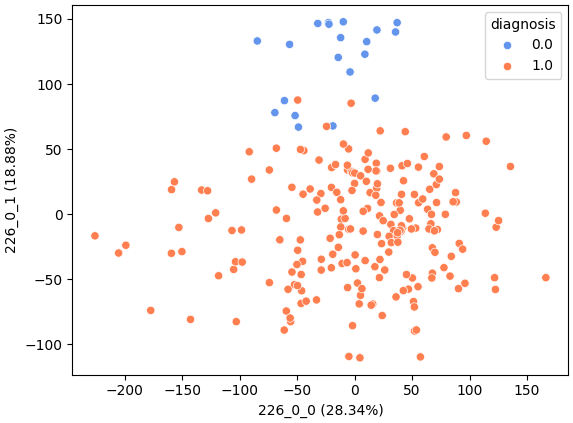

In [6]:
# PCA model
pca_model = multivariate.pca(data=data_normalised, n_components=np.min(data.shape), scale=True)

# Select components for plotting
PC_x = '226_0_0'
PC_y = '226_0_1'

# Get variance proportion of explained by PC_x and PC_y
var_x = np.round((pca_model.explained_variance_ratio.query(f"component == '{PC_x}'")["var"]*100).iloc[0], 2)
var_y = np.round((pca_model.explained_variance_ratio.query(f"component == '{PC_y}'")["var"]*100).iloc[0], 2)

# Plot the sample weights for the first two PCA components
sns.scatterplot(data=pca_model.sample_weights.join(metadata), 
                x=PC_x, 
                y=PC_y, 
                hue='diagnosis', 
                palette=
                {
                    0: 'cornflowerblue',
                    1: 'coral'
                }
               )

# Add labels and title
plt.xlabel(f"{PC_x} ({var_x}%)")
plt.ylabel(f"{PC_y} ({var_y}%)")

plt.show()


#### PLS analysis on disease severity

In [7]:
DIAGNOSIS_COLUMN = "diagnosis"
SEVERITY_COLUMNS = ["total_mayo_score", "histology_severity_score"]

##### 1) Evaluate model performance with different number of components

,r2_score,mse,mae,n_components
0,0.233949,4.822840,1.766874,1
0,0.299252,4.411711,1.659898,3
0,0.331019,4.211716,1.644989,5
0,0.359667,4.031356,1.600544,7
0,0.375472,3.931852,1.583045,9


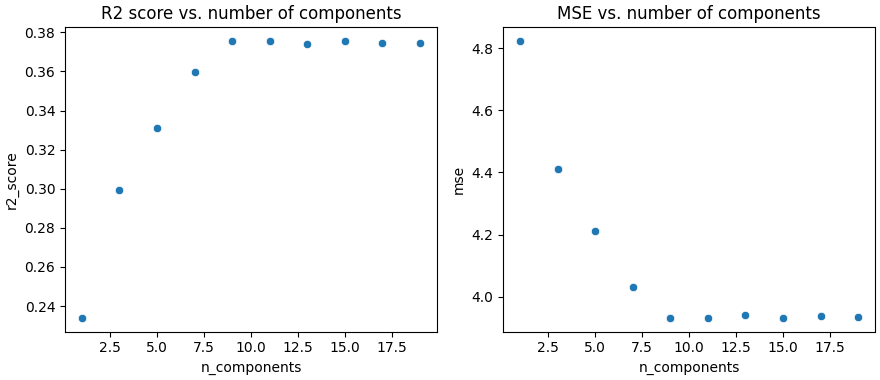

CPU times: user 3min 1s, sys: 30 s, total: 3min 31s
Wall time: 1min 57s


In [8]:
%%time

# Evaluate model performance with different number of components
metrics = pd.concat(
    [
        multivariate.cv_regression(
            PLSRegression(n_components=n_components, scale=True), 
            independent_variables=data_normalised, 
            dependent_variable=metadata[SEVERITY_COLUMNS[0]]
        ).assign(n_components=n_components)
        for n_components in range(1, 20, 2)
    ]
)

display(metrics.head())

# Plot metrics
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Plot r2_score
sns.scatterplot(data=metrics, x="n_components", y="r2_score", ax=axes[0])
axes[0].set_title("R2 score vs. number of components")

# Plot mse
sns.scatterplot(data=metrics, x="n_components", y="mse", ax=axes[1])
axes[1].set_title("MSE vs. number of components")

plt.tight_layout()
plt.show()


##### 2) Run the final model with the optimal number of components

In [9]:
# Run model with the optimal number of components
pls_model = multivariate.pls(
    independent_variables=data_normalised, 
    dependent_variable=metadata[SEVERITY_COLUMNS[0]], 
    n_components=10,
    scale=True
)

sample_weights = pls_model.sample_weights.copy(deep=True)
feature_weights = pls_model.feature_weights.copy(deep=True).T


##### 3) Align the sign of the components to the severity variable
Adjust the sign of `patient_weights` and `sample_weights` to ensure that the severe patients are always on the right side of the distribution. This facilitates the interpretation of the subsequent analyses.

In [10]:
associations_severity = association.correlation(sample_weights, metadata[[SEVERITY_COLUMNS[0]]])
components_to_flip = associations_severity.query("r < 0")["feature_a"]

feature_weights[components_to_flip] = -1*feature_weights[components_to_flip]
sample_weights[components_to_flip] = -1*sample_weights[components_to_flip]


##### 4) Scatter plot of sample weights across different components

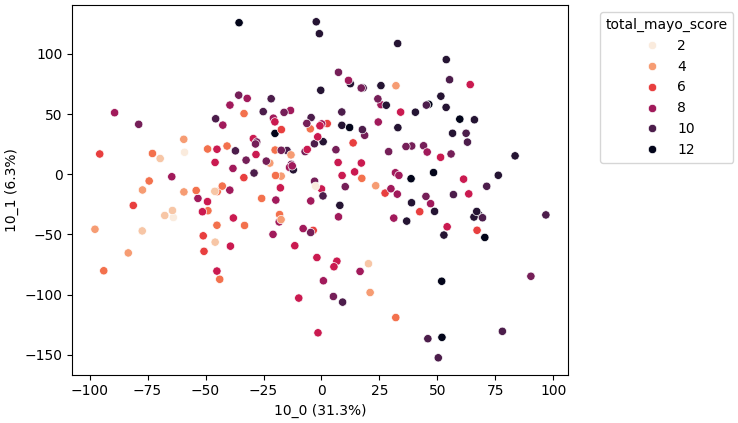

In [11]:
# Plot the sample weights for the first two PLS components
PC_x = '10_0'
PC_y = '10_1'

# Get variance proportion of explained by PC_x and PC_y
var_x = (pls_model.explained_variance_ratio.query(f"component == '{PC_x}'")["var"].round(3)*100).iloc[0]
var_y = (pls_model.explained_variance_ratio.query(f"component == '{PC_y}'")["var"].round(3)*100).iloc[0]

# Scatter plot of the sample weights for the first two PLS components
sns.scatterplot(data=pls_model.sample_weights.join(metadata), 
                x=PC_x, 
                y=PC_y, 
                hue=SEVERITY_COLUMNS[0], 
                palette = sns.color_palette("rocket_r", as_cmap=True)
               )

# Add labels and title
plt.xlabel(f"{PC_x} ({var_x}%)")
plt.ylabel(f"{PC_y} ({var_y}%)")

# Adjust legend position
plt.legend(title=SEVERITY_COLUMNS[0], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


#### Selection of the most relevant features

In [12]:
FEATURE_SELECTION_THRESHOLD = 0.15 # proportion of features to be selected from each tail


In [21]:
# Select the features that contribute the most to the first PLS component
feature_weights_pcx = pls_model.feature_weights.T[PC_x]
feature_weight_thresholds = feature_weights_pcx.quantile([FEATURE_SELECTION_THRESHOLD, 1-FEATURE_SELECTION_THRESHOLD]).to_list()

# Select top high and low features relative to the most severe patients
features_high = feature_weights_pcx[feature_weights_pcx > feature_weight_thresholds[1]].sort_values()
features_low = feature_weights_pcx[feature_weights_pcx < feature_weight_thresholds[0]].sort_values(ascending=False)

display(features_high.sort_values(ascending=False).head(10))
display(features_low.sort_values().head(10))


S100A12    0.025530
S100A8     0.024912
MCEMP1     0.024666
S100A9     0.023396
NFE2       0.023256
PROK2      0.022886
TRIB3      0.022756
FJX1       0.022546
TCN1       0.022421
MDFI       0.022402
Name: 10_0, dtype: float64

PCK1      -0.024473
CKB       -0.023784
TRPM6     -0.023517
SLC26A3   -0.023355
AQP8      -0.023156
ISX       -0.022560
ACSF2     -0.022288
USP2      -0.022167
SULT1A2   -0.022159
IHH       -0.022140
Name: 10_0, dtype: float64

#### Enrichment analysis

In [14]:
# Pathways "upregulated" in the most severe patients
pathways_enriched_high = enrichment.fisher(query=set(features_high.index), 
                                           annotation_mapper=pathway_mapper,
                                           space_size=data.shape[1]
                                          )
pathways_enriched_high.sort_values("pfdr").head(10)


,query,annotation_id,overlap,query_length,annotation_length,overlap_length,pvalue,pfdr
77,"{SMG9, ADORA1, UCN2, GOLGA6A, CTPS1, RHBDF2, A...",Cytokine-cytokine receptor interaction,"{CXCL16, LEP, IL12RB1, TNFRSF4, CD40, CXCL6, C...",2322,298,103,1.982211e-17,6.878273e-15
73,"{SMG9, ADORA1, UCN2, GOLGA6A, CTPS1, RHBDF2, A...",Complement and coagulation cascades,"{C1QA, C4BPA, CR1L, F3, C3AR1, MASP1, F2R, C4B...",2322,88,42,3.410394e-13,5.917033e-11
177,"{SMG9, ADORA1, UCN2, GOLGA6A, CTPS1, RHBDF2, A...",Malaria,"{CR1L, IL12A, CSF3, THBS2, CD40, MET, CXCL8, T...",2322,50,29,2.901813e-12,2.517322e-10
17,"{SMG9, ADORA1, UCN2, GOLGA6A, CTPS1, RHBDF2, A...",Amoebiasis,"{ARG2, COL1A2, SERPINB4, PRDX1, SERPINB6, LAMA...",2322,103,45,2.477438e-12,2.517322e-10
271,"{SMG9, ADORA1, UCN2, GOLGA6A, CTPS1, RHBDF2, A...",Rheumatoid arthritis,"{ATP6V1C1, ATP6V1F, IL17A, MMP1, CXCL6, CXCL8,...",2322,94,37,7.238008e-09,5.023178e-07
213,"{SMG9, ADORA1, UCN2, GOLGA6A, CTPS1, RHBDF2, A...",Osteoclast differentiation,"{LILRA2, TNFRSF11B, LILRB2, LILRA5, LCP2, SIRP...",2322,142,48,1.658376e-08,9.590939e-07
231,"{SMG9, ADORA1, UCN2, GOLGA6A, CTPS1, RHBDF2, A...",Pertussis,"{C1QA, C4BPA, CFL2, IL12A, C4B, CXCL6, C1S, CX...",2322,78,32,2.291825e-08,1.136090e-06
154,"{SMG9, ADORA1, UCN2, GOLGA6A, CTPS1, RHBDF2, A...",IL-17 signaling pathway,"{MMP13, LCN2, PTGS2, MMP9, CSF3, IL17A, MMP1, ...",2322,95,36,3.706830e-08,1.607838e-06
87,"{SMG9, ADORA1, UCN2, GOLGA6A, CTPS1, RHBDF2, A...",ECM-receptor interaction,"{COL6A2, COL1A2, ITGA2, CD44, LAMA4, ITGA8, LA...",2322,89,34,6.981566e-08,2.691782e-06
297,"{SMG9, ADORA1, UCN2, GOLGA6A, CTPS1, RHBDF2, A...",TNF signaling pathway,"{MAP3K8, PTGS2, MMP9, MMP14, RHBDF2, SOCS3, MA...",2322,119,41,9.903979e-08,3.436681e-06


In [15]:
# Pathways "downregulated" in the most severe patients
pathways_enriched_low = enrichment.fisher(query=set(features_low.index), 
                                          annotation_mapper=pathway_mapper,
                                          space_size=data.shape[1]
                                          )
pathways_enriched_low.sort_values("pfdr").head(6)


,query,annotation_id,overlap,query_length,annotation_length,overlap_length,pvalue,pfdr
273,"{ATP6V0D1, COQ5, SUCLG2, RNF135, CCHCR1, RBBP8...",Ribosome,"{RPS29, RPS27, RPL10L, RPL18A, RPL23, RPS18, R...",2322,172,86,2.107181e-27,7.311917e-25
183,"{ATP6V0D1, COQ5, SUCLG2, RNF135, CCHCR1, RBBP8...",Metabolic pathways,"{ATP6V0D1, COQ5, SUCLG2, COX5B, CHPT1, B3GALT1...",2322,1562,345,2.122629e-15,3.682762e-13
217,"{ATP6V0D1, COQ5, SUCLG2, RNF135, CCHCR1, RBBP8...",Oxidative phosphorylation,"{ATP6V0D1, UQCRB, NDUFA6, NDUFA7, UQCRFS1, COX...",2322,138,57,5.900488e-14,6.824898e-12
303,"{ATP6V0D1, COQ5, SUCLG2, RNF135, CCHCR1, RBBP8...",Thermogenesis,"{UQCRB, COX5B, SIRT6, COA3, PRKACB, NDUFS2, PP...",2322,235,78,1.756421e-12,1.523696e-10
59,"{ATP6V0D1, COQ5, SUCLG2, RNF135, CCHCR1, RBBP8...",Chemical carcinogenesis - reactive oxygen species,"{MAP2K2, CAT, UQCRB, NDUFA6, NDUFA7, UQCRFS1, ...",2322,226,71,2.904352e-10,2.015620e-08
82,"{ATP6V0D1, COQ5, SUCLG2, RNF135, CCHCR1, RBBP8...",Diabetic cardiomyopathy,"{UQCRB, NDUFA6, PPP1CC, NDUFA7, COX5B, UQCRFS1...",2322,205,66,3.878036e-10,2.242797e-08


In [16]:
# Pathways "disregulated" in the most severe patients
pathways_enriched_both = enrichment.fisher(query=set(features_low.index)|set(features_high.index), 
                                          annotation_mapper=pathway_mapper,
                                          space_size=data.shape[1]
                                          )
pathways_enriched_both.sort_values("pfdr").head(6)


,query,annotation_id,overlap,query_length,annotation_length,overlap_length,pvalue,pfdr
273,"{SMG9, ATP6V0D1, ADORA1, COQ5, SUCLG2, RNF135,...",Ribosome,"{RPS29, RPS27, RPL10L, RPL18A, RPL23, RPS18, R...",4644,172,87,1.114797e-08,0.000004
73,"{SMG9, ATP6V0D1, ADORA1, COQ5, SUCLG2, RNF135,...",Complement and coagulation cascades,"{KNG1, C1QA, PROC, C4BPA, CR1L, F3, C3AR1, MAS...",4644,88,47,3.734141e-06,0.000374
82,"{SMG9, ATP6V0D1, ADORA1, COQ5, SUCLG2, RNF135,...",Diabetic cardiomyopathy,"{UQCRB, PPP1CC, COX5B, COL1A1, NOS3, NDUFS2, M...",4644,205,92,4.307476e-06,0.000374
17,"{SMG9, ATP6V0D1, ADORA1, COQ5, SUCLG2, RNF135,...",Amoebiasis,"{ARG2, COL1A2, SERPINB4, PRDX1, SERPINB6, PLCB...",4644,103,53,4.056657e-06,0.000374
77,"{SMG9, ATP6V0D1, ADORA1, COQ5, SUCLG2, RNF135,...",Cytokine-cytokine receptor interaction,"{CXCL16, LEP, IL12RB1, TNFRSF4, CD40, MSTN, CX...",4644,298,125,6.697956e-06,0.000465
183,"{SMG9, ATP6V0D1, ADORA1, COQ5, SUCLG2, RNF135,...",Metabolic pathways,"{ATP6V0D1, ELOVL5, COQ5, SUCLG2, COX5B, CTPS1,...",4644,1562,542,1.394969e-05,0.000807


In [17]:
# Look up specific pathways
pathways_enriched_both[pathways_enriched_both["annotation_id"].str.contains("tnf", case=False)]

,query,annotation_id,overlap,query_length,annotation_length,overlap_length,pvalue,pfdr
297,"{SMG9, ATP6V0D1, ADORA1, COQ5, SUCLG2, RNF135,...",TNF signaling pathway,"{MAP3K8, PTGS2, MMP9, MMP14, RHBDF2, SOCS3, MA...",4644,119,47,0.016732,0.141613


#### Heatmap of pathway genes

In [18]:
PATHWAY_NAME = "TNF signaling pathway"


In [19]:
pathway_genes = list(pathways_enriched_both.loc[pathways_enriched_both["annotation_id"] == PATHWAY_NAME, "overlap"].iloc[0])


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 23.6375 mm


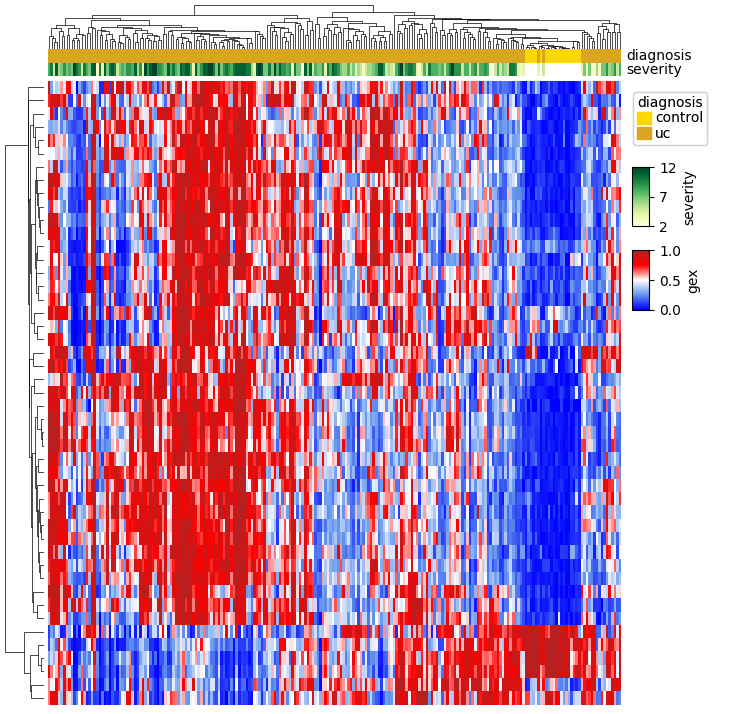

In [20]:
# Custome color palette for heatmap
color_names = ['blue', 'cornflowerblue', 'white', 'red', 'firebrick']

# Map the color names to RGB tuples using matplotlib's color dictionary
colors = [mcolors.to_rgb(color) for color in color_names]
nodes = list(np.arange(0, 1.25, 0.25))
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

# Annotation for samples
col_ha = pch.HeatmapAnnotation(
    diagnosis=pch.anno_simple(
        metadata[DIAGNOSIS_COLUMN].map({0: 'control', 1: 'uc'}),
        colors={'control': 'gold', 'uc': 'goldenrod'},
        #add_text=True,
        legend=True
    ), 
    severity=pch.anno_simple(metadata[SEVERITY_COLUMNS[0]], cmap='YlGn')
)

# Heatmap
plt.figure(figsize=(8, 8))

pch.ClusterMapPlotter(data=data_qt[pathway_genes].T, 
                      cmap=custom_cmap,
                      row_dendrogram=True, 
                      col_dendrogram=True, 
                      show_rownames=False,
                      show_colnames=False, 
                      label='gex',
                      top_annotation=col_ha
                     )

plt.show()
